<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/CurrentSourceInverter_sixStep_4DisplacementAngles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Current Source Inverter: Six-Step Opertion with Different Displacement Angles</h1></b>

Dr. Bingsen Wang

7/16/2023
</center>

#Python Code

This animimation illustrates the 6-step operation of a current source inverter at 4 different displacement angles: $0^\circ$, $\pm\ 90^\circ$, and $180^\circ$.

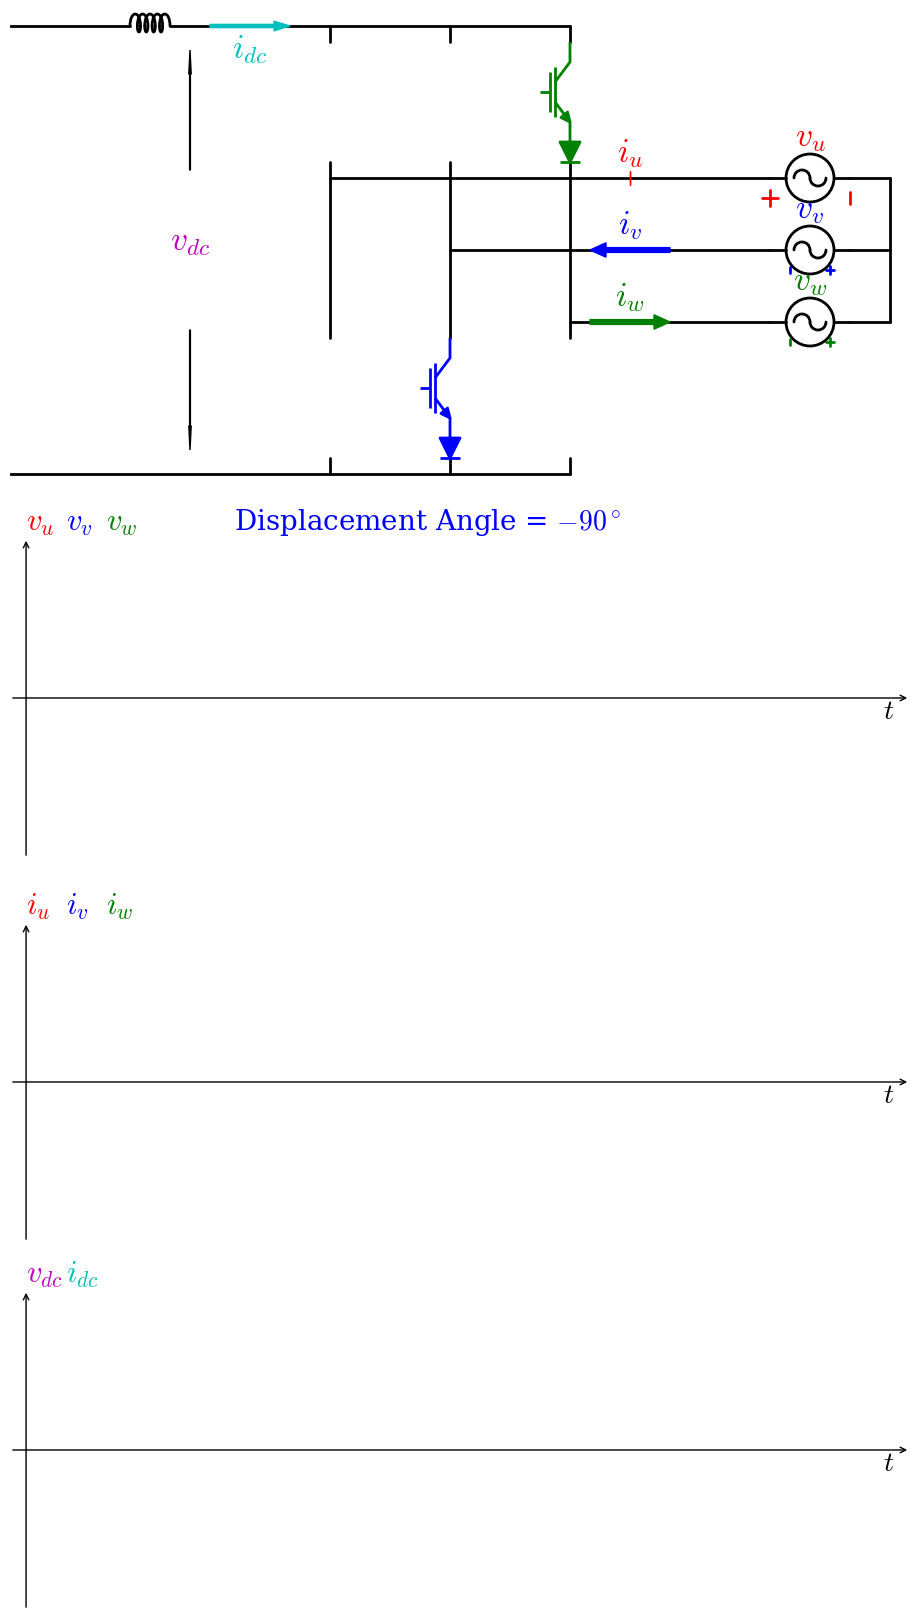

In [16]:
import matplotlib
from os import linesep
import numpy as np
from numpy import linspace,cos,pi,heaviside,fft,exp,arctan
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "Serif","mathtext.fontset" : "cm"})

#switching functions
def h(t,phi):
  ht=[]
  for k in range(3):
    ht_hi = heaviside(cos(2*pi*t-k*2*pi/3+phi) - cos(pi/3),0)
    ht_lo = heaviside(cos(2*pi*t-k*2*pi/3+phi+pi) - cos(pi/3),1)
    ht.append(ht_hi-ht_lo)
  return ht

#3-phase ac voltage source
def vac(t,f):
  v=[]
  for k in range(3):
    v.append(cos(2*pi*f*t-k*2*pi/3)) # back emf with u-phase having zero angle
  return v

#load currents
def iac(ht,idc):
  i_ac=[]
  for k in range(3):
    i_ac.append(ht[k]*idc)
  return i_ac

#dc link voltage
def vdc(ht,vact):
  v0 = ht[0]*vact[0]
  v1 = ht[1]*vact[1]
  v2 = ht[2]*vact[2]
  return v0+v1+v2


#draw diode symbol
def drawDiode(ax,x0,y0,h,theta,lw,color):
  codes=[Path.MOVETO,Path.LINETO]
  p2=mp.PathPatch(Path([(x0-.5*h,y0+h),(x0+h*.5,y0+h)], codes)) #cathode
  p3=mp.PathPatch(Path([(x0,y0+h),(x0-h*.5,y0),(x0+h*.5,y0),(x0,y0+h)],
                       codes+[Path.LINETO,Path.CLOSEPOLY])) #anode
  rot=transforms.Affine2D().rotate_deg_around(x0,y0+h*0.5,theta)+ax.transData
  kwargs=dict({'ec':color,'fc':['none',color],'lw':lw,'transform':rot})
  ax.add_collection(PatchCollection([p2,p3],**kwargs))
  return

#draw IGBT symbol
def drawIGBT(ax,x0,y0,h,theta,lw,color):
  codes1=[Path.MOVETO,Path.LINETO,Path.LINETO,Path.MOVETO,Path.LINETO,Path.LINETO]
  codes2=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p1=mp.PathPatch(Path([(x0,y0),(x0,y0+h*0.2),(x0-h*0.15,y0+h*0.4),
                        (x0-h*0.15,y0+h*0.6),(x0,y0+h*0.8),(x0,y0+h)], codes1))
  p2=mp.PathPatch(Path([(x0-h*0.15,y0+h*0.25),(x0-h*0.15,y0+h*0.75),
                        (x0-h*0.2,y0+h*0.3),(x0-h*0.2,y0+h*0.7),
                        (x0-h*0.3,y0+h*0.5),(x0-h*0.2,y0+h*0.5)], codes2))
  p3=mp.PathPatch(Path([(x0,y0+h*0.2),(x0-0.025*h,y0+h*0.3),(x0-h*0.09,y0+h*0.245),(x0,y0+h*0.2)],
                       [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY]))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  kwargs=dict({'ec':color,'fc':['none','none',color],'lw':lw,'transform':rot})
  ax.add_collection(PatchCollection([p1,p2,p3],**kwargs))


  # ax.add_collection(PatchCollection([p1,p2,p3],ec=color,fc=['none','none',color],lw=lw,transform=rot))
  return

#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  w= h/(0.7*n+0.3)#width of larger coil
  plg, psm = ([],[]) #the half coil with larger curvature
  codes=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)]
  for k in range(n):
    if k==0:
      plg.append(mp.PathPatch(Path(verts,codes)))
    else:
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),
                (x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)], codes)
      plg.append(mp.PathPatch(p))
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),
                (x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)], codes)
      psm.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  n: number of zig-zags; h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[] # container of the zig-zags
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#draw the CSI without switches, non-animated part
def drawCSIna(ax,lw,clst,txlst):
  tx_vac,tx_iac,tx_vdc,tx_idc = (txlst[0][0:3], txlst[1][0:3],txlst[2][0],txlst[2][1])
  codes=[Path.MOVETO,Path.LINETO]
  p_bus = Path([(-6,2.8),(-4.5,2.8),(-4,2.8),(1,2.8),(-6,-2.8),(1,-2.8)],
               codes+codes+codes)
  args = dict({'lw':lw,'capstyle':'round'})
  args1=  dict({'size':24,'ha':'center'})
  ax.add_patch(mp.PathPatch(p_bus,**args)) #+/- dc rails
  drawInductor(ax,-4.5,2.8,5,.5,0,lw,'k') #inductor
  codes1=codes+codes+codes
  for k in range(3):
    x,y = (-2+k*1.5, .9-0.9*k)
    p1 = Path([(x,2.8), (x,2.6), (x,1.1), (x,-1.1), (x,-2.6),(x,-2.8)],codes1)
    p2=Path([(x,y),(3.5,y),(4.5,y),(5,y)],codes+codes)
    ax.add_patch(mp.PathPatch(p1,**args)) #vertical bridge lines
    ax.add_patch(mp.PathPatch(p2,**args)) #horizontal load lines
    drawVoltSourceAc(ax,3.5,y,1,0,lw,'k')
    ax.text(1.75,.2+y,tx_iac[k],color=clst[k],**args1)
    ax.text(4,.4+y,tx_vac[k],color=clst[k],**args1)
  p_ldend = Path([(5,0.9),(5,-0.9)], codes)
  ax.add_patch(mp.PathPatch(p_ldend,**args)) #load end
  ax.add_patch(mp.Arrow(-3.5,2.8,1,0,width=0.2,color=clst[-1])) #dc link current
  ax.text(-3,2.4,tx_idc,color=clst[-1],**args1) #label "i_dc"
  ax.add_patch(mp.Arrow(-3.75,1,0,1.5,width=0.05,color='k')) #dc link voltage
  ax.add_patch(mp.Arrow(-3.75,-1,0,-1.5,width=0.05,color='k')) #dc link voltage
  ax.text(-3.75,0,tx_vdc,color=clst[-2],**args1) #label "v_dc"
  return

#draw the animated part of the VSI
def drawCSIanim(ax,mh,iac,vac,vdc,lw):
  for k in range(3):
    #IGBT & Diode transparency depends on the current direction and mod function
    x,dx=(-2+1.5*k,1.5*k)
    drawIGBT(ax,x,1.35,1.25,0,lw, to_rgba(clst[k],max(mh[k],0))) #high side IGBT
    drawDiode(ax,x,1.1,.25,180,lw,to_rgba(clst[k],max(mh[k],0))) #high side diode
    drawIGBT(ax,x,-2.35,1.25,0,lw, to_rgba(clst[k],max(-mh[k],0)))#low side IGBT
    drawDiode(ax,x,-2.6,.25,180,lw,to_rgba(clst[k],max(-mh[k],0)))#low side diode
    ax.add_patch(mp.Arrow(1.75 - 0.5*iac[k],0.9-k*0.9,
                          iac[k],0,width=0.3,color=clst[k])) #load current
    drawVoltSign(ax,4,0.65-k*0.9,vac[k],0,2,clst[k]) #load volt sign
    drawVoltSign(ax,-3.75,0,vdc,-90,2,clst[3]) #load volt sign
  return

#parameters
idc=1
f=1
phi_d = [-90,0,90,180]
clst=['r','b','g','m','c'] #list of colors used for plots
Nfpp = 480
Nf = Nfpp*4
t=linspace(0,1/f,Nfpp)
vact = vac(t,f)
idct = idc+t*0

#set up figures
fig = plt.figure(figsize=(9,16)) #overall plot area
fig.tight_layout()
km = 1.1 # margin
ax_frame = [[(0,.47, 1, .2),[-.02,1.1],[-1.1,1.1]], #v_uvw
            [(0,.23, 1, .2),[-.02,1.1],[-1.1,1.1]], #i_uvw
            [(0,0, 1, .2),[-.02,1.1],[-1.1,1.1]], #v_dc,i_dc
            [(0,.7 , 1, .3),[-6,5.25],[-3,3]], #circuit diagram
            [(0,.7 , 1, .3),[-6,5.25],[-3,3]], #animated circuit
            ]# [pos-boundary, xlim, ylim] for subplots

ax_lbl=[['$v_u$', '$v_v$', '$v_w$', '$t$'],
        ['$i_u$','$i_v$', '$i_w$', '$t$'],
        ['$v_{dc}$','$i_{dc}$','$t$'],
        ] #variables for yx axes of each subplot

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
ax_lst=[] #axis list or the list of subplots
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=ax_frame[k][1], ylim=ax_frame[k][2],
                  fc='none') #remove frame face color
  ax.axis('off') #turn the first 2 axes for circuit digram completely off
  ax_lst.append(ax)
  if k<3:
    ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
    ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
    ax.text(xm-.02,0,ax_lbl[k][-1],size=20,va='top',ha='right') #x-axis label
    for kk in range(len(ax_lbl[k])-1):
      if k<2:
        ax.text(0.05*kk,ym,ax_lbl[k][kk],size=22,va='bottom',color=clst[kk]) #y-axis label
        lines.append(ax.plot([],[],color=clst[kk],lw=3)[0])
      else:
        ax.text(0.05*kk,ym,ax_lbl[k][kk],size=22,va='bottom',color=clst[kk+3]) #y-axis label
        lines.append(ax.plot([],[],color=clst[kk+3],lw=3)[0])
txt_title = ax_lst[0].text(0.5,1.1,'',size=20,ha='center',va='bottom',color='b')
# animation function. This is called sequentially
def animate(i):
  kk=int(i/Nfpp)
  i = i%Nfpp
  txt_title.set_text('Displacement Angle = $'+str(phi_d[kk])+'^\circ$')
  ht = h(t,phi_d[kk]/180*pi)
  iact = ht*idc
  vdct = vdc(ht,vact)
  for k in range(3):
    lines[k].set_data(t[0:i],vact[k][0:i])
    lines[k+3].set_data(t[0:i],iact[k][0:i])
  lines[6].set_data(t[0:i],vdct[0:i]*.5)
  lines[7].set_data(t[0:i],idct[0:i])
  ax_lst[-1].clear()
  ax_lst[-1].set_xlim(-6,5.25)
  ax_lst[-1].set_ylim(-3,3)
  ax_lst[-1].axis('off')
  drawCSIanim(ax_lst[-1],[ht[0][i],ht[1][i],ht[2][i]],
    [iact[0][i],iact[1][i],iact[2][i]],
    [vact[0][i],vact[1][i],vact[2][i]],vdct[i],2)
  return

drawCSIna(ax_lst[-2],2,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"CSI_6step_4DisplacementAngles.mp4"
writervideo = animation.FFMpegWriter(fps=60)
anim.save(fn, writer=writervideo,dpi = 120)

#debug
# drawCSIanim(ax_lst[-1],[1,-1,0],[1,-0.5,-0.5],[1,-0.5,-0.5],1.5,2)
# ax_lst[0].plot(t,vact[0])
# ax_lst[0].plot(t,vact[1])
# ax_lst[0].plot(t,vact[2])
# ax_lst[1].plot(t,ht[0])
# ax_lst[1].plot(t,ht[1])
# ax_lst[1].plot(t,ht[2])